Session 0.0: Load packages and customised functions

In [1]:
## a useful function to generate a data list for further analysis
import os,json,sys,itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file
from data_cleaning import preprocess_fictrac_data
from locustvr_converter import preprocess_matrex_data

Session 0.1: Load analysis methods in python dictionary form

In [2]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    

#Put the folder of your Unity experiment below
thisDataset ="D:/MatrexVR_Swarm_Data/RunData"

In [3]:
analysis_methods

{'experiment_name': 'swarm',
 'overwrite_curated_dataset': True,
 'graph_colour_code': ['r', 'b', 'g', 'k', 'c', 'y', 'm', 'r'],
 'debug_mode': False,
 'fictrac_posthoc_analysis': True,
 'use_led_to_align_stimulus_timing': True,
 'align_with_isi_onset': False,
 'filtering_method': 'sg_filter',
 'plotting_tbt_overview': True,
 'plotting_trajectory': True,
 'plotting_event_related_trajectory': False,
 'plotting_deceleration_accerleration': False,
 'plotting_optomotor_response': True,
 'generate_locust_vr_matrices': True,
 'load_individual_data': True,
 'select_animals_by_condition': True,
 'analysis_by_stimulus_type': False,
 'camera_fps': 120,
 'trackball_radius_cm': 0.5,
 'monitor_fps': 60,
 'body_length': 12,
 'growth_condition': 'G'}

Session 0.2: Load animals' experiment directory into a list

In [4]:
## this cell searches for a folder with a specified experiment_name under the dataset path and list up all the dat file in that folder.
## In this project, we usually have one dat file in that folder so there is no confusion
dir_list = []
file_type=".csv"
for root, dirs, files in os.walk(thisDataset):
    for folder in dirs:
        folder_path=os.path.join(root,folder)
        if any(name.endswith(file_type) for name in os.listdir(folder_path)):
            dir_list.append(folder_path.replace("\\", "/"))


print(f"these directories are found {dir_list}")

these directories are found ['D:/MatrexVR_Swarm_Data/RunData/20240809_123816', 'D:/MatrexVR_Swarm_Data/RunData/20240812_141356', 'D:/MatrexVR_Swarm_Data/RunData/20240812_145552', 'D:/MatrexVR_Swarm_Data/RunData/20240815_134157', 'D:/MatrexVR_Swarm_Data/RunData/20240815_151307', 'D:/MatrexVR_Swarm_Data/RunData/20240815_170111', 'D:/MatrexVR_Swarm_Data/RunData/20240816_131610', 'D:/MatrexVR_Swarm_Data/RunData/20240816_145830', 'D:/MatrexVR_Swarm_Data/RunData/20240816_163744', 'D:/MatrexVR_Swarm_Data/RunData/20240817_133502', 'D:/MatrexVR_Swarm_Data/RunData/20240817_150931', 'D:/MatrexVR_Swarm_Data/RunData/20240817_164418', 'D:/MatrexVR_Swarm_Data/RunData/20240818_134521', 'D:/MatrexVR_Swarm_Data/RunData/20240818_152457', 'D:/MatrexVR_Swarm_Data/RunData/20240818_170807', 'D:/MatrexVR_Swarm_Data/RunData/20240824_143943', 'D:/MatrexVR_Swarm_Data/RunData/20240824_163554', 'D:/MatrexVR_Swarm_Data/RunData/20240824_184143', 'D:/MatrexVR_Swarm_Data/RunData/20240825_132616', 'D:/MatrexVR_Swarm_Da

Session 0.3: select animal based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [59]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
        animal_of_interest=select_animals_gpt(df,"Stimulus Type (list up all the stimulus paradigm this animal receive)","kappa")
        #print(animal_of_interest)
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values
    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

Session 1.0: Create curated dataset based on a list of experiment directories

In [ ]:
pattern="VR*.h5"
for this_dir in dir_list:
    if any(Path(this_dir).glob(pattern)) and analysis_methods.get("overwrite_curated_dataset")==False:
        print(f"curated matrexvr h5 database found in {this_dir}. Skip this file")
        continue
    else:
        print(f"no curated matrexvr h5 database in {this_dir}. Create curated file")
        preprocess_matrex_data(this_dir,analysis_methods)

Session 2.0: introduce customised plotting functions used in Sercan's paper

In [93]:
#introduce customised functions
def plot_sercansincos(df,parameters):
    cos = df["cos"]
    sin = df["sin"]
    density=df["density"].unique()[0]
    fig, ax = plt.subplots(dpi=300, figsize=(1.1,0.25))
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    plt.set_cmap('cividis')

    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['font.family'] = 'Arial'
    sns.kdeplot(cos, cut=0, color="#21918c", fill=True, alpha=0.9)#)#, lw=1


    plt.xlim(-1,1)
    #ax.xaxis.tick_top()
    #plt.ylim(0,np.max(sin))
    plt.title("r cos\u03F4")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #plt.xticks(rotation = 90)
    ax.set_yticks([])
    plt.ylabel("")
    plt.xlabel("")
    #ax.set_xticks([])
    plt.rcParams.update({'font.size': 8})
    #plt.gca().set_aspect('equal')
    #plt.savefig(savefolder + "/plot_noabs.svg")
    #plt.tight_layout()
    plt.subplots_adjust(bottom=0.4)
    plt.savefig(f"cos_{parameters}_{int(density)}.svg")
    plt.show()   

    fig, ax = plt.subplots(dpi=300, figsize=(1.1,0.25))
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['font.family'] = 'Arial'
    sns.kdeplot(sin, cut=0, color="#21918c",  fill=True, alpha=0.9)#),lw=1,
    plt.xlim(1,-1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.xticks(rotation = 90)
    ax.set_yticks([])
    plt.ylabel("")
    plt.xlabel("")
    plt.title("r sin\u03F4")

    plt.rcParams.update({'font.size': 8})

    plt.subplots_adjust(bottom=0.4)
    plt.savefig(f"sin_{parameters}_{int(density)}.svg")
    plt.show()
def plot_sercantrajec(dfXY,parameters,trajec_lim=1000):
    #trajec_lim=1000
    a = dfXY.groupby('VR')
    density=dfXY["density"].unique()[0]
    fig, ax = plt.subplots(figsize=(1.1,1.1), dpi=300) 
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['font.family'] = 'Helvetica'
    # Get the colormap
    cmap = plt.get_cmap('viridis')
    # Get the total number of trajectories
    n = len(a)

    #plt.style.use('dark_background') 
    for i, (key2, grp2) in enumerate(a):
        xx = grp2["X"].values
        yy = grp2["Y"].values
        color = cmap(i/n)
        plt.plot(xx, yy, color=color, linewidth=1)

        # Calculate angles, radii, etc. (your existing code)

    plt.xlim(-1*trajec_lim, trajec_lim)
    plt.ylim(-1*trajec_lim, trajec_lim)
    plt.yticks([-1*trajec_lim, 0, trajec_lim])
    plt.xticks([-1*trajec_lim, 0, trajec_lim])


    #plt.title("Density 16\nOrder 1", fontsize=8)                                                           

    plt.savefig(f"summary_trajectory_{parameters}_{int(density)}.png")
    # Set the aspect ratio to be equal
    plt.gca().set_aspect('equal')
    plt.show()

Session 2.1: plot responses (mean angle and travel distance) from individual experiments (usually every 4 animal an experiment; different colour mark different animals in that experiment) 

or comparing trial by trial response through normalised response (e.g. ratio to previous trial) or scatter plot (each dot means a comparison, different colour means data from different rigs, different alpha value means different kappa value)

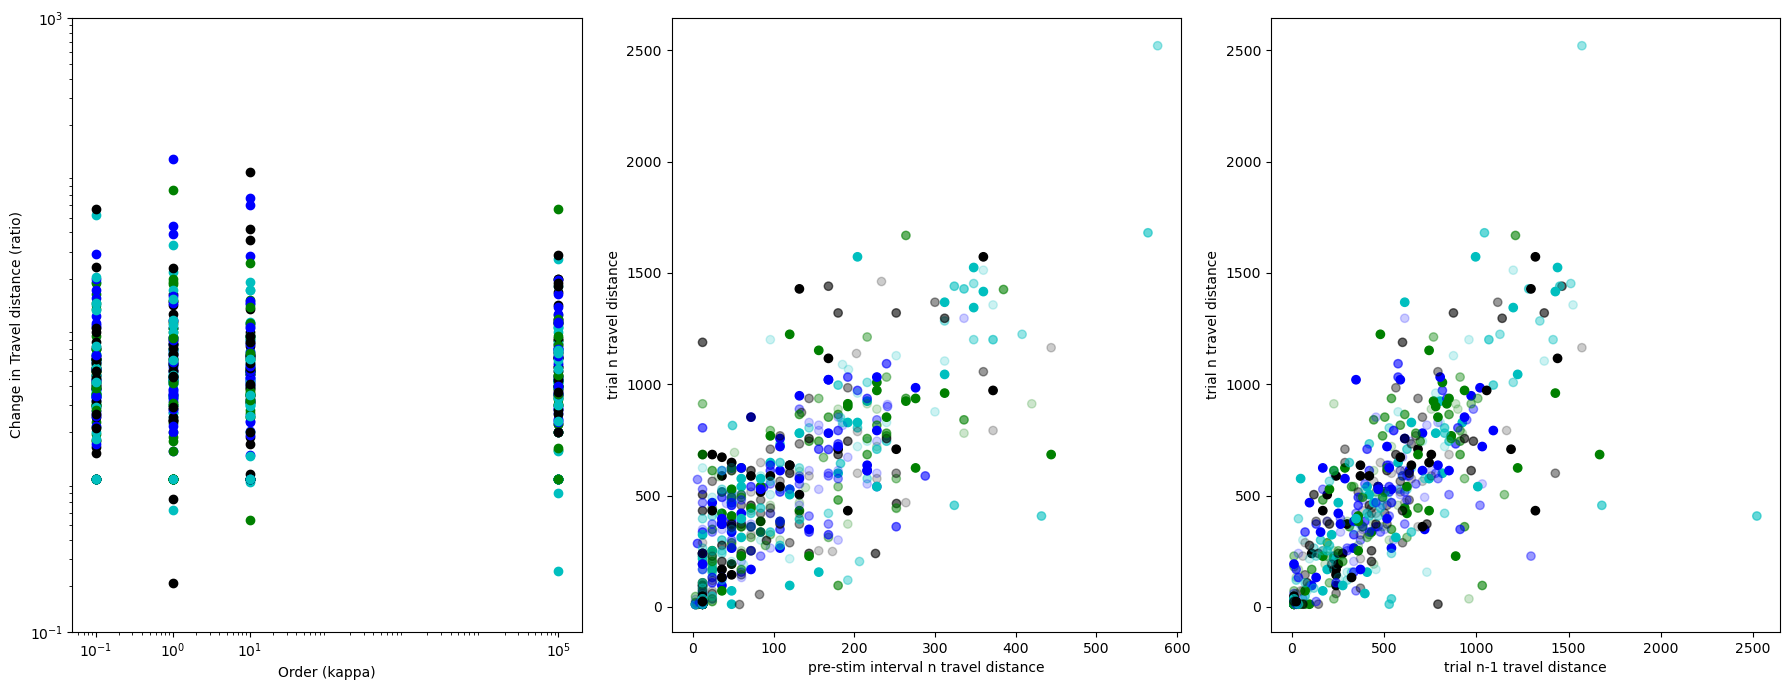

In [61]:
## plot individual experiment will generate plots with kappa value against travel distance or walking angle
num_vr=4
plot_individual_experiment=False
colour_code=analysis_methods.get("graph_colour_code")
if 'vr_no' in locals() and plot_individual_experiment ==False:
    fig, (ax1, ax2,ax3) = plt.subplots(
    nrows=1, ncols=3, figsize=(18, 7), tight_layout=True
)
    alpha_dictionary = {0.1: 0.2, 1.0: 0.4, 10.0: 0.6,100000.0:1}
    colour_code=analysis_methods.get("graph_colour_code")
    y_axis_lim=[0.1,1000]
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylim([y_axis_lim[0],y_axis_lim[1]])
    ax1.set(
        yticks=[y_axis_lim[0], y_axis_lim[1]],
        ylabel="Change in Travel distance (ratio)",
        xticks=list(alpha_dictionary.keys()),
        xlabel="Order (kappa)",
    )
    ax2.set(
        ylabel="trial n travel distance",
        xlabel="pre-stim interval n travel distance",
    )
    ax3.set(
        ylabel="trial n travel distance",
        xlabel="trial n-1 travel distance",
    )
    df_all=[]
    dfxy_all=[]
    for this_dir,this_vr in zip(dir_list,vr_no):
    #for this_dir,this_vr in dir_dict:    
        this_color=colour_code[this_vr]
        summary_pattern = f"VR{this_vr}*score.h5"
        xy_pattern = f"VR{this_vr}*XY.h5"
        found_result = find_file(Path(this_dir), summary_pattern)        
        df = pd.read_hdf(found_result)
        df['VR'] = np.tile(f"VR{this_vr}", (len(df), 1))
        df['VR'] =df["VR"]+"_"+df["fname"]
        found_result = find_file(Path(this_dir), xy_pattern)
        dfxy = pd.read_hdf(found_result)
        dfxy['VR'] = np.tile(f"VR{this_vr}", (len(dfxy), 1))
        dfxy['VR'] =dfxy["VR"]+"_"+dfxy["fname"]
        #set some thresholds to remove back tracking 
        df.loc[(df["distTotal"]<10.0) | (df["loss"]> 0.05), "distTotal"] = np.nan
        df['alpha'] = df['order'].map(alpha_dictionary)
        df_all.append(df)
        dfxy_all.append(dfxy)
        ax1.scatter(df.iloc[3::2]["order"], df[3::2]["distTotal"]/df[2:-1:2]["distTotal"],c=this_color)
        ax1.scatter(df.iloc[1]["order"], df.iloc[1]["distTotal"]/df.iloc[0]["distTotal"]*5,c=this_color)
        ax2.scatter(df.iloc[0]["distTotal"]/5,df.iloc[1]["distTotal"],c=this_color,alpha=df.iloc[1]['alpha'])
        ax2.scatter(df[2:-1:2]["distTotal"],df.iloc[3::2]["distTotal"],c=this_color,alpha=df.iloc[3::2]['alpha'])
        ax3.scatter(df.iloc[1:-2:2]["distTotal"], df[3::2]["distTotal"],c=this_color,alpha=df.iloc[3::2]['alpha']) 
elif plot_individual_experiment ==True:
    h5_pattern=("VR*score.h5")
    if dir_list[0]==dir_list[1]:
        for this_dir in dir_list[::num_vr]:
            h5_dirs=find_file(this_dir,h5_pattern)
            fig = plt.figure(figsize=(18, 5),tight_layout=True)
            ax1 = plt.subplot2grid((1, 18), (0, 0),colspan=8)
            ax2 = plt.subplot2grid((1, 18), (0, 8))
            ax3 = plt.subplot2grid((1, 18), (0, 9),colspan=8)
            ax4 = plt.subplot2grid((1, 18), (0, 17))
            for idx,this_file in enumerate(h5_dirs):
                this_color=colour_code[idx]
                if this_file.stem in ['VR4_Swarm_2024-08-16_131719_score','VR4_Swarm_2024-08-16_145857_score']:
                    continue
                df = pd.read_hdf(this_file)
                df_stim = df.loc[(df['loss'] < 0.05) & (df['distTotal'] >= 12)&(df ['density'] > 0)] 
                df_stim = df_stim.reset_index(drop=True)
                ax1.set_xscale('log')
                ax1.set_ylim([-4,4])        
                ax3.set_xscale('log')
                ax3.set_ylim([1,2000])
                ax1.scatter(df_stim['order'], df_stim['mean_angle'],c=this_color)
                ax3.scatter(df_stim['order'], df_stim['distTotal'],c=this_color)
                ax2.set_ylim([-4,4])
                ax2.set_yticks([])
                ax2.set_xticks([])
                ax4.set_ylim([1,1000])
                ax4.set_yticks([])
                ax4.set_xticks([])
                df_isi = df.loc[(df['loss'] < 0.05) & (df['distTotal'] >= 12)&(df ['density'] == 0)]
                df_isi = df_isi.reset_index(drop=True)
                if len(df_isi)>0:
                    ax2.scatter(df_isi.iloc[0]['order']/2, df_isi.iloc[0]['mean_angle'],c=this_color)
                    #ax2.scatter(df.iloc[-1]['order'], df.iloc[-1]['mean_angle'],c=this_color,alpha=0.2)
                    ax4.scatter(df_isi.iloc[0]['order']/2, df_isi.iloc[0]['distTotal'],c=this_color)
                    #ax4.scatter(df.iloc[-1]['order'], df.iloc[-1]['distTotal'],c=this_color,alpha=0.2)

plt.show()

Session 2.3: make summary plots of animals' response with customised functions introduced before.

In [62]:
#Firstly, concatenate every animal's dataframe into a big table and then sort them based on conditions.
if len(dfxy_all)>0:
    dfxy_con = pd.concat(dfxy_all)
if len(df_all)>0:
    df_con = pd.concat(df_all)
good_tracking=df_con['loss'] < 0.05

order:0.1


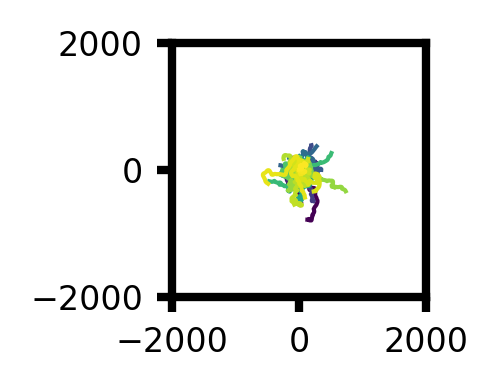

order:1.0


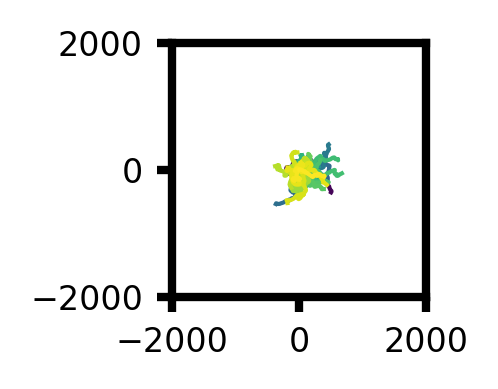

order:10.0


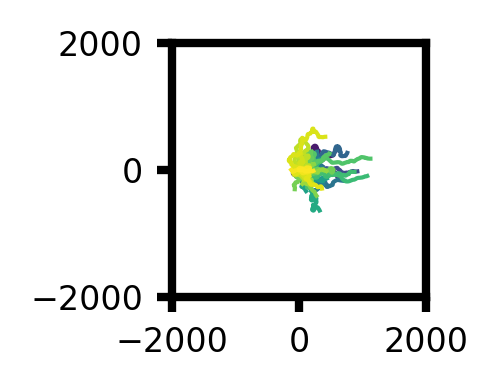

order:100000.0


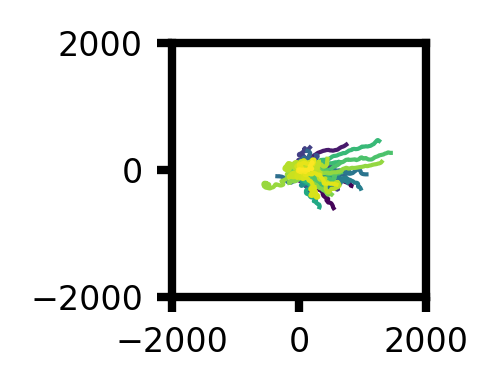

In [94]:
df_stim=dfxy_con.loc[(dfxy_con['VR'].isin(df_con["VR"][good_tracking])) & (dfxy_con['density']>0)]
for key, grp in df_stim.groupby('order'):
    print(f"order:{key}")
    plot_sercantrajec(grp,key,2000)

order:1.0


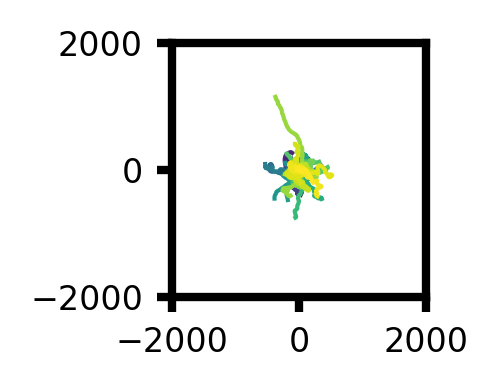

In [95]:
df_isi=dfxy_con.loc[(dfxy_con['VR'].isin(df_con["VR"][good_tracking])) & (dfxy_con['density']==0)]
for key, grp in df_isi.groupby('order'):
    print(f"order:{key}")
    plot_sercantrajec(grp,key,2000)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


order:0.1


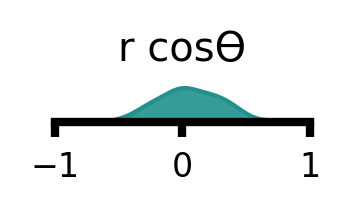

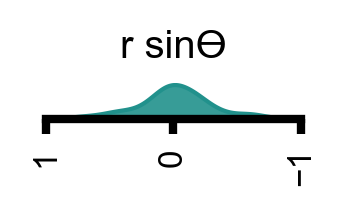

order:1.0


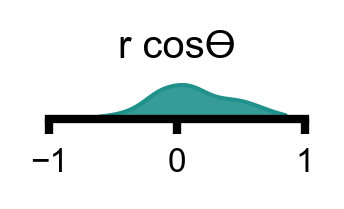

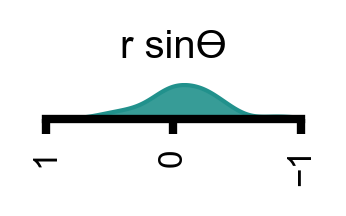

order:10.0


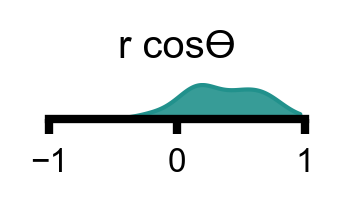

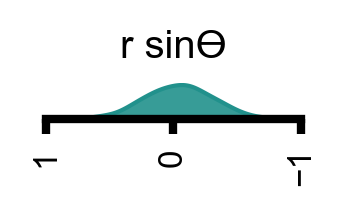

order:100000.0


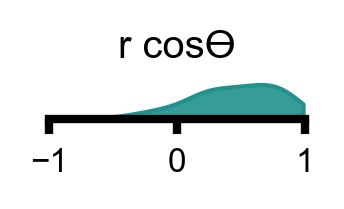

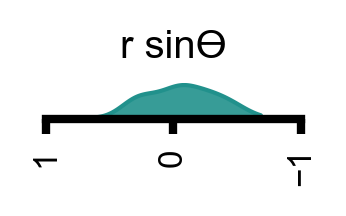

In [96]:
df_stim=df_con[df_con['density']>0]
for key, grp in df_stim.groupby('order'):
    print(f"order:{key}")
    plot_sercansincos(grp,key)

order:1.0


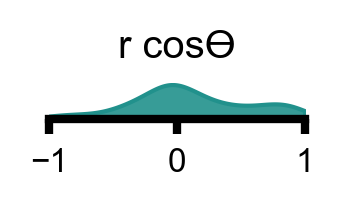

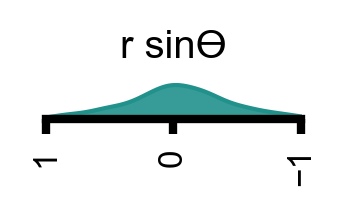

In [97]:
df_isi=df_con[df_con['density']==0]
for key, grp in df_isi.groupby('order'):
    print(f"order:{key}")
    plot_sercansincos(grp,key)

In [ ]:
if 'vr_no' in locals():
    for this_dir,this_vr in zip(dir_list,vr_no):
        this_color=colour_code[this_vr]
        locust_pattern = f"VR{this_vr}*score.h5"
        found_result = find_file(Path(this_dir), locust_pattern)        
        df = pd.read_hdf(found_result)
        df.loc[(df["distTotal"]<5) | (df["loss"]> 0.05), "distTotal"] = np.nan
        df_stim=df[df['density']>0]
        df_isi=df[df['density']==0]
        for key, grp in df_stim.groupby('order'):
            print(f"order:{key}")
            plot_sercantrajec(grp,2000)
            plot_sercansincos(grp)
else:
    h5_pattern=("VR*score.h5")
    for this_dir in dir_list:
        h5_dirs=find_file(this_dir,h5_pattern)

extra session: Analyse data with multi-engines

In [8]:
##this cell start the multi-engines. Make sure to run only once
import time
import ipyparallel as ipp
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))
    return cluster_id

cluster = ipp.Cluster(n=6)
await cluster.start_cluster()
cluster_neuropc=show_clusters()

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
cluster_id        state    cluster_file
1724918107-ytld  running   C:\Users\neuroPC\.ipython\profile_default\security\cluster-1724918107-ytld.json


In [ ]:
##input cluster_id from previous cell
rc = ipp.Client(cluster_id=cluster_neuropc)

# Create a DirectView for parallel execution
dview = rc.direct_view()

# Define a function for parallel processing
def process_directory(this_dir, analysis_methods):
    from pathlib import Path
    import sys
    current_working_directory = Path.cwd()
    parent_dir = current_working_directory.resolve().parents[0]
    sys.path.insert(0, str(parent_dir) + "\\utilities")
    from locustvr_converter import preprocess_matrex_data
    preprocess_matrex_data(this_dir,analysis_methods)

# Define analysis_methods

# Use parallel execution to process directories
dview.map_sync(process_directory, dir_list, [analysis_methods] * len(dir_list))

# # Initialize result lists
# output0_across_exp=[]
# output1_across_exp=[]
# output2_across_exp=[]

# # Collect and organize results
# for result in results:
#     if result is not None:
#         summary,speed,rotation = result
#         output0_across_exp.append(summary)
#         output1_across_exp.append(speed)
#         output2_across_exp.append(rotation)

# # Now, you have the results collected in the respective lists

In [ ]:
rc.shutdown()